# 神經網路實做

## 拿取加權指數資料

In [81]:
#!pip install pandas --upgrade

In [82]:
from finlab.data import Data

data = Data()
twii = data.get("發行量加權股價指數")

twii = twii['台股指數'].resample("1D").first().dropna()  #resample("15T")
twii.head()

date
2006-01-02    6548.34
2006-01-03    6462.06
2006-01-04    6591.77
2006-01-05    6616.44
2006-01-06    6709.87
Name: 台股指數, dtype: float64

## 製作features

In [83]:
import talib
import numpy as np
import pandas as pd

sma = talib.SMA(twii, timeperiod=120)
wma = talib.WMA(twii, timeperiod=120)
mom = talib.MOM(twii, timeperiod=120)
k, d = talib.STOCH  (twii, twii, twii, fastk_period=120, slowk_period=60, slowd_period=60)
k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=240, slowk_period=120, slowd_period=120)
k3, d3 = talib.STOCH(twii, twii, twii, fastk_period=360, slowk_period=180, slowd_period=180)
k4, d4 = talib.STOCH(twii, twii, twii, fastk_period=480, slowk_period=240, slowd_period=240)
k5, d5 = talib.STOCH(twii, twii, twii, fastk_period=640, slowk_period=320, slowd_period=320)
k6, d6 = talib.STOCH(twii, twii, twii, fastk_period=720, slowk_period=360, slowd_period=360)
k7, d7 = talib.STOCH(twii, twii, twii, fastk_period=840, slowk_period=420, slowd_period=420)
k8, d8 = talib.STOCH(twii, twii, twii, fastk_period=960, slowk_period=480, slowd_period=480)

rsi = talib.RSI (twii, timeperiod=120)
rsi2 = talib.RSI(twii, timeperiod=240)
rsi3 = talib.RSI(twii, timeperiod=480)
rsi4 = talib.RSI(twii, timeperiod=640)
rsi5 = talib.RSI(twii, timeperiod=720)
rsi6 = talib.RSI(twii, timeperiod=840)

macd1, macd2, macd3 = talib.MACD(twii, fastperiod=120, slowperiod=60, signalperiod=60)
willr = talib.WILLR(twii, twii, twii, timeperiod=120)
cci = talib.CCI(twii, twii, twii, timeperiod=120)

dataset = pd.DataFrame({
    'RSIb': rsi / 50,
    'RSIb2': rsi2 / 50,
    'RSIb3': rsi3 / 50,
    'RSIb4': rsi4 / 50,
    'RSIb5': rsi5 / 50,
    'RSIb6': rsi6 / 50,
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    'KDb8': k8 - d8,
    
    'a5':   (twii.rolling(5).mean()   / twii),
    'a10':  (twii.rolling(10).mean()  / twii),
    'a20':  (twii.rolling(20).mean()  / twii),
    'a40':  (twii.rolling(40).mean()  / twii),
    'a80':  (twii.rolling(80).mean()  / twii),
    'a160': (twii.rolling(160).mean() / twii),
    'a320': (twii.rolling(320).mean() / twii),
    'a640': (twii.rolling(640).mean() / twii),
    'a720': (twii.rolling(720).mean() / twii),
    'a840': (twii.rolling(840).mean() / twii),
    'a960': (twii.rolling(960).mean() / twii),
    'a1024':(twii.rolling(1024).mean() / twii),
    'b1': twii/twii.shift(50),
    'b2': twii/twii.shift(100),
    'b3': twii/twii.shift(150),
    'b4': twii/twii.shift(200),
    'b5': twii/twii.shift(250),
    'b6': twii/twii.shift(300),
    'b7': twii/twii.shift(350),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(twii, 60),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(twii, 120),

    'ADXR0': talib.ADXR(twii, twii, twii, 60),
    'ADXR1': talib.ADXR(twii, twii, twii, 120),
    'ADXR2': talib.ADXR(twii, twii, twii, 240),
    'ADXR3': talib.ADXR(twii, twii, twii, 360),
    'ADXR4': talib.ADXR(twii, twii, twii, 480),
    'ADXR5': talib.ADXR(twii, twii, twii, 640),

    'return': twii.shift(-2) / twii,
})

feature_names = list(dataset.columns[:-1])

## 簡單處理一下

In [84]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)


before dropping NaN (4237, 43)
after dropping NaN (2317, 43)


In [85]:
import lightgbm as lgb
dataset_train = dataset[:'2021']

gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)

gbm.fit(dataset_train[feature_names], dataset_train['return'] > 1)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 神經網路Preprocessing

In [86]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,RSIb,RSIb2,RSIb3,RSIb4,RSIb5,RSIb6,MOMb,KDb,KDb2,KDb3,...,b7,LINEARREG_SLOPE0,LINEARREG_SLOPE1,ADXR0,ADXR1,ADXR2,ADXR3,ADXR4,ADXR5,return
count,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,...,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2.317000e+03,2317.000000
mean,2.600759e-15,4.120331e-16,4.640560e-15,-5.036804e-15,-1.933738e-15,5.190784e-16,-2.421935e-16,-6.861629e-17,-3.099712e-16,-1.090577e-16,...,4.092061e-16,2.491653e-18,-4.312476e-17,-3.964483e-17,3.238430e-16,8.769660e-16,-3.060900e-16,9.717446e-16,-5.527636e-16,1.000630
std,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,...,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,1.000216e+00,0.013586
min,-3.441134e+00,-3.041552e+00,-2.698517e+00,-2.506874e+00,-2.404331e+00,-2.250242e+00,-3.502323e+00,-2.760083e+00,-2.386570e+00,-2.356072e+00,...,-1.988014e+00,-3.293241e+00,-2.876905e+00,-1.735135e+00,-1.507221e+00,-1.468919e+00,-1.218973e+00,-1.050331e+00,-1.154644e+00,0.919670
25%,-5.826139e-01,-6.661451e-01,-6.476351e-01,-6.452506e-01,-6.490703e-01,-6.555016e-01,-3.997498e-01,-4.573411e-01,-6.549287e-01,-5.157002e-01,...,-8.287731e-01,-3.896599e-01,-3.587378e-01,-6.987080e-01,-7.479092e-01,-7.039494e-01,-7.790539e-01,-8.742974e-01,-7.034077e-01,0.993191
50%,1.095774e-01,2.027505e-02,-8.005276e-02,-1.440358e-01,-1.673102e-01,-1.780072e-01,7.013589e-02,7.052108e-03,4.687587e-02,-1.310656e-02,...,2.340210e-02,5.745907e-02,6.845844e-02,-2.528207e-01,-2.270005e-01,-2.917572e-01,-2.004421e-01,-2.996182e-01,-3.836568e-01,1.001478
75%,6.739675e-01,6.396809e-01,5.023364e-01,4.031202e-01,3.599810e-01,3.275093e-01,4.033924e-01,5.517600e-01,5.902555e-01,6.922695e-01,...,4.413517e-01,4.807892e-01,4.243320e-01,4.517035e-01,4.472583e-01,3.532030e-01,3.433283e-01,5.484282e-01,4.514476e-01,1.008826
max,2.809247e+00,2.760112e+00,2.992083e+00,3.021554e+00,3.017061e+00,2.992807e+00,3.348453e+00,2.576621e+00,2.135074e+00,1.760641e+00,...,4.003383e+00,2.886428e+00,2.911530e+00,3.606180e+00,2.689817e+00,2.373338e+00,2.183838e+00,2.138277e+00,2.054083e+00,1.084895


In [87]:
import tqdm

n = 3

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled['return'].iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])
#dataset_scaled.head()

In [88]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [89]:
indexes = np.array(indexes)

## 神經網路 Model

In [90]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential()
#model.add(keras.layers.Dense(100, activation="relu", input_shape=(len(feature_names),)))
model.add(layers.LSTM(100, return_sequences=True, input_shape=X[0].shape))
model.add(layers.LSTM(100))
model.add(layers.Dense(8))
model.add(layers.Dense(1,kernel_initializer="uniform",activation='linear'))

adam = keras.optimizers.Adam(0.0006)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 100)            57200     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 8)                 808       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 138,417
Trainable params: 138,417
Non-trainable params: 0
_________________________________________________________________


## 神經網路訓練

In [91]:
# dataset_scaled_train = dataset_scaled[:'2015']

import datetime
X_train = X[indexes < datetime.datetime(2022, 1, 1)]
y_train = y[indexes < datetime.datetime(2022, 1, 1)]

checkpoint_filepath = './checkpoint_u22'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    X_train,
    y_train > 1,
    batch_size=5000,
    epochs=300,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback])

Epoch 1/300
1/1 [==============================] - 5s 5s/step - loss: 6.4035 - accuracy: 0.4479 - val_loss: 8.5295 - val_accuracy: 0.3990
Epoch 2/300
1/1 [==============================] - 0s 94ms/step - loss: 4.6148 - accuracy: 0.4479 - val_loss: 8.5364 - val_accuracy: 0.3990
Epoch 3/300
1/1 [==============================] - 0s 408ms/step - loss: 3.9843 - accuracy: 0.4479 - val_loss: 8.4153 - val_accuracy: 0.3990
Epoch 4/300
1/1 [==============================] - 0s 330ms/step - loss: 3.5480 - accuracy: 0.4479 - val_loss: 8.1626 - val_accuracy: 0.3990
Epoch 5/300
1/1 [==============================] - 0s 298ms/step - loss: 3.1364 - accuracy: 0.4479 - val_loss: 7.8602 - val_accuracy: 0.3990
Epoch 6/300
1/1 [==============================] - 0s 346ms/step - loss: 2.7670 - accuracy: 0.4479 - val_loss: 7.2937 - val_accuracy: 0.3990
Epoch 7/300
1/1 [==============================] - 0s 360ms/step - loss: 2.4936 - accuracy: 0.4479 - val_loss: 6.9585 - val_accuracy: 0.3990
Epoch 8/300
1/1 [

In [92]:
model.load_weights(checkpoint_filepath)

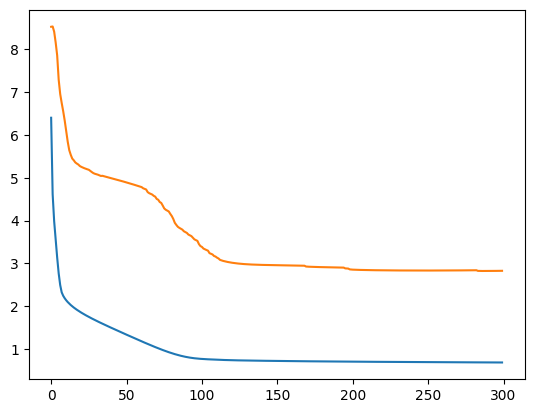

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## 回測

73/73 [==============================] - 1s 3ms/step


<AxesSubplot:>

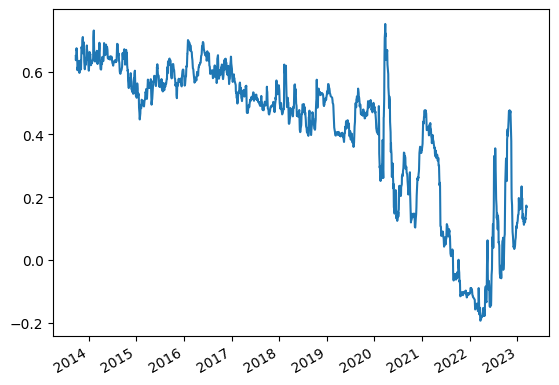

In [94]:
ey = model.predict(X)
ey = pd.Series(ey.swapaxes(0,1)[0], index=indexes)
ey.plot()

<AxesSubplot:xlabel='date'>

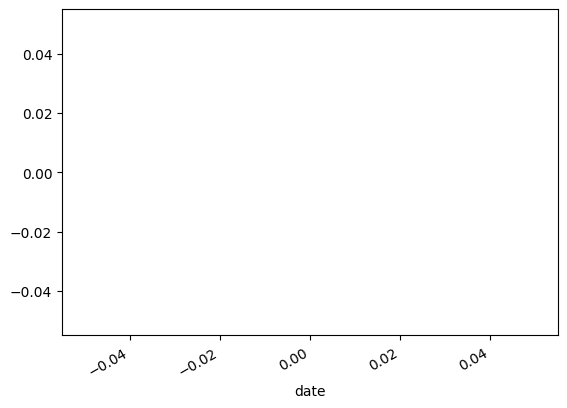

In [95]:
eq = twii[indexes]
returns = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.6)).rolling(10).sum() > 0
signal = signal.shift(1).fillna(False)

eq = (returns[signal]['2022':]).cumsum()
eq.plot()

In [96]:
(signal.astype(int).diff().abs().fillna(0) * 3)['2022':].sum()

0.0